In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)
print(tf.config.list_physical_devices('GPU'))

2025-09-29 08:12:43.964232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.20.0
3.11.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing untuk Time Series

## Windowing Dataset pakai metode sliding window

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("./DailyDelhiClimateTrain.csv")
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

```python
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
```

### Parameter

* **series**: data deret waktu (time series).
* **window_size**: ukuran jendela (window) yang akan digunakan.
* **batch_size**: ukuran batch.
* **shuffle_buffer**: ukuran buffer untuk pengacakan (shuffle).

---

### Langkah-langkah dalam fungsi

1. ```python
   series = tf.expand_dims(series, axis=-1)
   ```

   * Menambahkan satu dimensi baru di posisi terakhir (`axis=-1`).
   * Berguna untuk menangani data deret waktu yang hanya punya satu fitur (misalnya, `meantemp`).

2. ```python
   ds = tf.data.Dataset.from_tensor_slices(series)
   ```

   * Membuat dataset TensorFlow dari `series`.
   * Dataset ini berisi potongan (slice) di mana setiap slice adalah satu elemen dari `series`.

3. ```python
   ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
   ```

   * Membagi dataset menjadi jendela berukuran `window_size + 1`.
   * `shift=1` → jendela bergeser satu langkah tiap kali.
   * `drop_remainder=True` → buang jendela yang panjangnya kurang dari `window_size + 1`.

4. ```python
   ds = ds.flat_map(lambda w: w.batch(window_size + 1))
   ```

   * Mengubah setiap window menjadi batch berukuran `window_size + 1`.
   * `flat_map` digunakan untuk menggabungkan hasil pemetaan dari setiap window.

5. ```python
   ds = ds.shuffle(shuffle_buffer)
   ```

   * Mengacak dataset dengan ukuran buffer `shuffle_buffer`.
   * Berguna untuk memperkenalkan variasi dalam pelatihan model.

6. ```python
   ds = ds.map(lambda w: (w[:-1], w[-1:]))
   ```

   * Memetakan setiap batch menjadi pasangan **(input, target)**:

     * Input → semua elemen kecuali yang terakhir (`w[:-1]`).
     * Target → elemen terakhir (`w[-1:]`).
   * Membuat model bisa belajar memprediksi elemen berikutnya berdasarkan data sebelumnya.

7. ```python
   return ds.batch(batch_size).prefetch(1)
   ```

   * Mengelompokkan dataset ke dalam batch berukuran `batch_size`.
   * `prefetch(1)` → memastikan ada 1 batch yang selalu siap diproses.
   * Meningkatkan efisiensi pelatihan.

---

### Ringkasan

Fungsi `windowed_dataset` mengubah data deret waktu menjadi dataset jendela (windowed dataset), di mana setiap window digunakan untuk melatih model agar dapat **memprediksi nilai berikutnya** berdasarkan nilai sebelumnya.


In [5]:
dates = df["date"].values
temp = df["meantemp"].values

In [8]:
train_set = windowed_dataset(temp, window_size=2, batch_size=3, shuffle_buffer=1000)

I0000 00:00:1759110634.294642    6448 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2286 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:02:00.0, compute capability: 8.6


In [12]:
for data in train_set:
    print(data)
    break

(<tf.Tensor: shape=(3, 2, 1), dtype=float64, numpy=
array([[[28.875     ],
        [31.38888889]],

       [[25.75      ],
        [26.625     ]],

       [[16.125     ],
        [15.5       ]]])>, <tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[34.70588235]],

       [[28.5       ]],

       [[16.625     ]]])>)


In [13]:
count = 0
for _ in train_set:
    count += 1
print(count)

487


2025-09-29 08:53:43.839417: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Latihan: Time Series 101

## Univariate Time Series

Univariate time series adalah serangkaian data yang direkam dalam interval waktu yang berurutan, di mana setiap titik data memiliki satu variabel yang diamati atau diukur. Ini berarti bahwa dalam analisis univariate time series, kita hanya memperhatikan satu variabel dalam rentang waktu tertentu.

In [14]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
df = pd.read_csv("./DailyDelhiClimateTrain.csv")
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [17]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [18]:
df.duplicated().sum()

0

In [19]:
dates = df['date'].values
temp  = df['meantemp'].values

Text(0.5, 1.0, 'Temperature average')

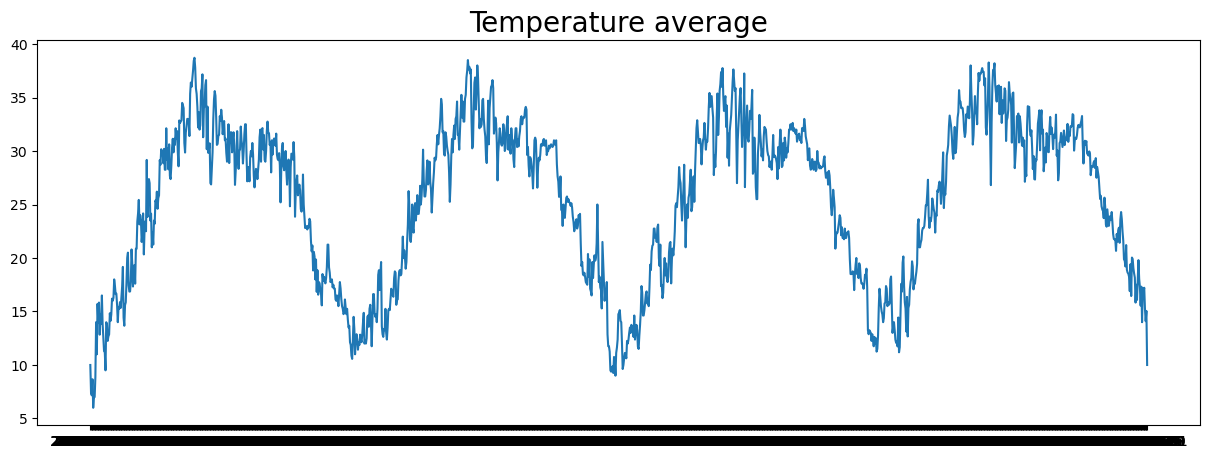

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(dates, temp)
plt.title("Temperature average", fontsize=20)

ternyata seasonal

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [22]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100


2025-09-29 09:15:59.865948: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 25.1351 - mae: 25.6351
Epoch 2/100
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 25.1379 - mae: 25.6379  

2025-09-29 09:16:01.241860: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
/home/ayam/miniconda3/envs/tf220/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.9241 - mae: 25.4241
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24.6653 - mae: 25.1653
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.4089 - mae: 24.9089
Epoch 5/100


2025-09-29 09:16:01.638745: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.1426 - mae: 24.6426
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 23.8542 - mae: 24.3542
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 23.5316 - mae: 24.0316
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.1602 - mae: 23.6602
Epoch 9/100


2025-09-29 09:16:02.330726: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.7221 - mae: 23.2221
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.1874 - mae: 22.6874
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.4868 - mae: 21.9868
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.5873 - mae: 21.0873
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.4314 - mae: 19.9314
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.9086 - mae: 18.4086
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.8498 - mae: 16.3488
Epoch 16/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.0561 - mae: 13.5499
Epoch 17/100


2025-09-29 09:16:03.602871: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8141 - mae: 10.3052 
Epoch 18/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0882 - mae: 7.5795
Epoch 19/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6263 - mae: 6.1150
Epoch 20/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0396 - mae: 5.5262
Epoch 21/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9161 - mae: 5.3985
Epoch 22/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7625 - mae: 5.2407
Epoch 23/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4856 - mae: 4.9659
Epoch 24/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3943 - mae: 4.8787
Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2131 - mae: 4.6924
Epoch 26/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3483 - mae: 3.8228
Epoch 27/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7959 - mae: 5.2788
Epoch 28/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5662 - mae: 4.0386
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━

2025-09-29 09:16:06.409685: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5576 - mae: 2.0050
Epoch 34/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5947 - mae: 2.0459
Epoch 35/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4690 - mae: 1.9149
Epoch 36/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4727 - mae: 1.9183
Epoch 37/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5802 - mae: 2.0287
Epoch 38/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4239 - mae: 1.8656
Epoch 39/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4217 - mae: 1.8663
Epoch 40/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4275 - mae: 1.8737
Epoch 41/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3001 - mae: 1.7359
Epoch 42/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3443 - mae: 1.7866
Epoch 43/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2859 - mae: 1.7254
Epoch 44/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3263 - mae: 1.7622
Epoch 45/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0

2025-09-29 09:16:10.401302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1945805192024227500
2025-09-29 09:16:10.401340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3794830382327624719


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2306 - mae: 1.6656
Epoch 56/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2142 - mae: 1.6511
Epoch 57/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1283 - mae: 1.5604
Epoch 58/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1823 - mae: 1.6113
Epoch 59/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1589 - mae: 1.5928
Epoch 60/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4680 - mae: 1.9116
Epoch 61/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1580 - mae: 1.5925
Epoch 62/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2448 - mae: 1.6828
Epoch 63/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1512 - mae: 1.5855
Epoch 64/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1013 - mae: 1.5292
Epoch 65/100


2025-09-29 09:16:12.167873: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0842 - mae: 1.5144
Epoch 66/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1817 - mae: 1.6146
Epoch 67/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3274 - mae: 1.7667
Epoch 68/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0756 - mae: 1.5040
Epoch 69/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4089 - mae: 1.8517
Epoch 70/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3123 - mae: 1.7528
Epoch 71/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1402 - mae: 1.5741
Epoch 72/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1727 - mae: 1.6037
Epoch 73/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0975 - mae: 1.5254
Epoch 74/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2328 - mae: 1.6656 
Epoch 75/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3572 - mae: 1.7979
Epoch 76/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1272 - mae: 1.5580
Epoch 77/100


2025-09-29 09:16:14.521480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3529311865327837263
2025-09-29 09:16:14.521504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3794830382327624719
2025-09-29 09:16:14.521513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1945805192024227500


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0757 - mae: 1.5025
Epoch 78/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0857 - mae: 1.5128
Epoch 79/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0707 - mae: 1.4974
Epoch 80/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1914 - mae: 1.6259
Epoch 81/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1588 - mae: 1.5888
Epoch 82/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5406 - mae: 1.9875
Epoch 83/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1502 - mae: 1.5779
Epoch 84/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3429 - mae: 1.7819
Epoch 85/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0749 - mae: 1.4993
Epoch 86/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0641 - mae: 1.4890
Epoch 87/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0488 - mae: 1.4773
Epoch 88/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2189 - mae: 1.6549
Epoch 89/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0

2025-09-29 09:16:16.859789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3794830382327624719


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2571 - mae: 1.6971
Epoch 91/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1201 - mae: 1.5504
Epoch 92/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1123 - mae: 1.5386
Epoch 93/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1204 - mae: 1.5476
Epoch 94/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1116 - mae: 1.5430
Epoch 95/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0898 - mae: 1.5176
Epoch 96/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1319 - mae: 1.5632
Epoch 97/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0317 - mae: 1.4547
Epoch 98/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0463 - mae: 1.4673
Epoch 99/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0973 - mae: 1.5280
Epoch 100/100


2025-09-29 09:16:18.631503: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3794830382327624719


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0651 - mae: 1.4897


In [24]:
forecast = history.model.predict(train_set)
forecast

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[19.833767],
       [18.426012],
       [31.965155],
       ...,
       [32.226456],
       [33.122738],
       [31.14226 ]], dtype=float32)

## Multivariate Time Series

Multivariate time series adalah rangkaian data di mana setiap titik data terdiri dari beberapa variabel yang diamati atau diukur secara bersamaan dalam interval waktu yang berurutan. Berbeda dengan univariate time series, kita tidak hanya melihat satu variabel pada satu waktu tertentu, tetapi sejumlah variabel yang diamati secara bersamaan. Ini memungkinkan kita untuk memahami bagaimana variabel-variabel tersebut berinteraksi satu sama lain seiring waktu.

In [31]:
df = pd.read_csv("./household_power_consumption.csv", sep=',',
                     infer_datetime_format=True, index_col='datetime', header=0)
df.head()

/tmp/ipykernel_6448/3537779213.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("./household_power_consumption.csv", sep=',',


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86400 entries, 2006-12-16 17:24:00 to 2007-02-14 17:23:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    86400 non-null  float64
 1   Global_reactive_power  86400 non-null  float64
 2   Voltage                86400 non-null  float64
 3   Global_intensity       86400 non-null  float64
 4   Sub_metering_1         86400 non-null  float64
 5   Sub_metering_2         86400 non-null  float64
 6   Sub_metering_3         86400 non-null  float64
dtypes: float64(7)
memory usage: 5.3+ MB


In [34]:
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data
data = df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

In [35]:
N_FEATURES = len(df.columns)

In [36]:
SPLIT_TIME = int(len(data) * 0.5)
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]

In [37]:
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

```python
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
```

### Parameter

* **series**: data berurutan yang akan diproses.
* **batch_size**: ukuran batch yang akan digunakan dalam dataset.
* **n_past**: jumlah waktu ke belakang yang akan dipertimbangkan sebagai input.
* **n_future**: jumlah waktu ke depan yang akan dipertimbangkan sebagai output.
* **shift**: perpindahan (shift) dalam jumlah waktu saat membuat jendela waktu.

👉 Perbedaan utama dibanding versi sebelumnya ada pada tiga argumen terakhir (`n_past`, `n_future`, dan `shift`).

---

### Langkah-langkah dalam fungsi

1. ```python
   ds = tf.data.Dataset.from_tensor_slices(series)
   ```

   * Membuat dataset TensorFlow dari array `series` menggunakan `from_tensor_slices`.
   * Setiap elemen dalam dataset sesuai dengan elemen pada array `series`.

2. ```python
   ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
   ```

   * Membagi dataset menjadi jendela (window).
   * `size` = jumlah waktu ke belakang + jumlah waktu ke depan.
   * `shift` = berapa langkah dataset bergeser antar jendela.
   * `drop_remainder=True` → buang jendela yang ukurannya tidak penuh.

3. ```python
   ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
   ```

   * Menggunakan `flat_map` untuk mengubah setiap window menjadi batch dengan ukuran `n_past + n_future`.
   * Hasil window digabungkan kembali ke dalam dataset.

4. ```python
   ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
   ```

   * Setiap batch dibagi menjadi pasangan `(input, output)`:

     * Input = `w[:n_past]` → data sepanjang `n_past` waktu sebelumnya.
     * Output = `w[n_past:]` → data sepanjang `n_future` waktu sesudahnya.
   * Inilah yang membuat model bisa belajar **multi-step forecasting**.

5. ```python
   return ds.batch(batch_size).prefetch(1)
   ```

   * Dataset dikelompokkan dalam batch berukuran `batch_size`.
   * `prefetch(1)` memastikan selalu ada 1 batch siap diproses → efisiensi lebih tinggi karena overlap antara loading data dan komputasi.

---

### Ringkasan

Fungsi `windowed_dataset` ini membentuk dataset untuk **multi-step forecasting**:

* **`n_past`** menentukan panjang input (berapa data lampau yang dipakai).
* **`n_future`** menentukan panjang output (berapa data masa depan yang diprediksi).
* **`shift`** menentukan seberapa banyak dataset bergeser antar window.

Dengan fungsi ini, kita bisa melatih model agar tidak hanya memprediksi **1 langkah ke depan**, tapi juga beberapa langkah ke depan sekaligus.


In [38]:
BATCH_SIZE = 32
N_PAST = 24
N_FUTURE = 24
SHIFT = 1
# Kode untuk membuat windowed datasets
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)

In [39]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape=(N_PAST, N_FEATURES)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(N_FEATURES)
    ])

/home/ayam/miniconda3/envs/tf220/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('mae') < 0.055 and logs.get('val_mae') < 0.055):
                self.model.stop_training = True
 
callbacks = myCallback()

In [41]:
# Kode untuk melakukan menyusun struktur sesuai dengan machine learning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 
model.compile(loss='mae',
                  optimizer= optimizer,
                  metrics=["mae"])

In [42]:
model.fit(train_set,
          validation_data=(valid_set),
          epochs=100,
          callbacks=callbacks,
          verbose=1
    )

Epoch 1/100


2025-09-29 10:20:09.116284: I external/local_xla/xla/service/service.cc:163] XLA service 0x7bd7980c4890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-29 10:20:09.116304: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-09-29 10:20:09.149232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-29 10:20:09.304177: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 10:20:10.187770: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spi

     83/Unknown 3s 2ms/step - loss: 0.1586 - mae: 0.1586

I0000 00:00:1759116011.412446   23740 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1329/Unknown 5s 2ms/step - loss: 0.0825 - mae: 0.0825

2025-09-29 10:20:13.949076: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 10:20:14.801288: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 312 bytes spill stores, 312 bytes spill loads

2025-09-29 10:20:14.811630: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 12 bytes spill stores, 12 bytes spill loads



   1349/Unknown 7s 3ms/step - loss: 0.0823 - mae: 0.0823

2025-09-29 10:20:15.732681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
/home/ayam/miniconda3/envs/tf220/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-09-29 10:20:15.732700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.0600 - val_mae: 0.0600
Epoch 2/100
  77/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0640 - mae: 0.0640

2025-09-29 10:20:18.859134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:18.859154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1335/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0604 - mae: 0.0604

2025-09-29 10:20:21.563575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:21.563598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0596 - mae: 0.0596 - val_loss: 0.0594 - val_mae: 0.0594
Epoch 3/100
  79/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0626 - mae: 0.0626

2025-09-29 10:20:24.189860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:24.189899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1337/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0597 - mae: 0.0597

2025-09-29 10:20:26.936413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:26.936439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0590 - mae: 0.0590 - val_loss: 0.0584 - val_mae: 0.0584
Epoch 4/100
  85/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0604 - mae: 0.0604

2025-09-29 10:20:29.491021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:29.491040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1326/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0588 - mae: 0.0588

2025-09-29 10:20:32.052769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:32.052789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0584 - mae: 0.0584 - val_loss: 0.0586 - val_mae: 0.0586
Epoch 5/100
  76/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0608 - mae: 0.0608

2025-09-29 10:20:34.659718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:34.659739: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1335/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0582 - mae: 0.0582

2025-09-29 10:20:37.359994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:37.360019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0579 - mae: 0.0579 - val_loss: 0.0582 - val_mae: 0.0582
Epoch 6/100
  82/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0602 - mae: 0.0602

2025-09-29 10:20:39.930703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:39.930731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1343/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0581 - mae: 0.0581

2025-09-29 10:20:42.610968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:42.610989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0577 - mae: 0.0577 - val_loss: 0.0566 - val_mae: 0.0566
Epoch 7/100
  79/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0594 - mae: 0.0594

2025-09-29 10:20:45.175978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:45.176001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1328/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0577 - mae: 0.0577

2025-09-29 10:20:47.881232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:47.881254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0575 - mae: 0.0575 - val_loss: 0.0574 - val_mae: 0.0574
Epoch 8/100
  72/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0597 - mae: 0.0597

2025-09-29 10:20:50.542628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:50.542652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1338/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0575 - mae: 0.0575

2025-09-29 10:20:53.451871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:53.451895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0570 - mae: 0.0570 - val_loss: 0.0572 - val_mae: 0.0572
Epoch 9/100
  80/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0597 - mae: 0.0597

2025-09-29 10:20:56.238720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:56.238743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1340/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0574 - mae: 0.0574

2025-09-29 10:20:58.869921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:20:58.869942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0571 - mae: 0.0571 - val_loss: 0.0571 - val_mae: 0.0571
Epoch 10/100
  84/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0586 - mae: 0.0586

2025-09-29 10:21:01.415177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:01.415205: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1340/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0572 - mae: 0.0572

2025-09-29 10:21:04.045560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:04.045582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0567 - mae: 0.0567 - val_loss: 0.0567 - val_mae: 0.0567
Epoch 11/100
  83/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0579 - mae: 0.0579

2025-09-29 10:21:06.764573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:06.764593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1325/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0569 - mae: 0.0569

2025-09-29 10:21:09.372368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:09.372388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0567 - mae: 0.0567 - val_loss: 0.0564 - val_mae: 0.0564
Epoch 12/100
  82/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0577 - mae: 0.0577

2025-09-29 10:21:11.953315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:11.953337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1333/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0568 - mae: 0.0568

2025-09-29 10:21:14.811291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:14.811313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0565 - mae: 0.0565 - val_loss: 0.0564 - val_mae: 0.0564
Epoch 13/100
  72/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0574 - mae: 0.0574

2025-09-29 10:21:17.676110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:17.676131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0564 - mae: 0.0564 - val_loss: 0.0565 - val_mae: 0.0565
Epoch 14/100
  81/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0573 - mae: 0.0573

2025-09-29 10:21:23.192008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:23.192027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1348/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0564 - mae: 0.0564

2025-09-29 10:21:25.860010: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-09-29 10:21:25.860030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:25.860039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0562 - mae: 0.0562 - val_loss: 0.0569 - val_mae: 0.0569
Epoch 15/100
  82/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0569 - mae: 0.0569

2025-09-29 10:21:28.467116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:28.467136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1335/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0563 - mae: 0.0563

2025-09-29 10:21:31.049883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:31.049904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0562 - mae: 0.0562 - val_loss: 0.0558 - val_mae: 0.0558
Epoch 16/100
  77/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0566 - mae: 0.0566

2025-09-29 10:21:33.590705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:33.590727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1336/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0562 - mae: 0.0562

2025-09-29 10:21:36.180017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:36.180039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0561 - mae: 0.0561 - val_loss: 0.0575 - val_mae: 0.0575
Epoch 17/100
  84/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0561 - mae: 0.0561

2025-09-29 10:21:38.719242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:38.719261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1334/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0562 - mae: 0.0562

2025-09-29 10:21:41.470119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:41.470141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0562 - mae: 0.0562 - val_loss: 0.0567 - val_mae: 0.0567
Epoch 18/100
  84/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0560 - mae: 0.0560

2025-09-29 10:21:44.053954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:44.053976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1322/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0559 - mae: 0.0559

2025-09-29 10:21:46.616929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0559 - mae: 0.0559 - val_loss: 0.0556 - val_mae: 0.0556
Epoch 19/100
  57/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0556 - mae: 0.0556

2025-09-29 10:21:49.508418: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:49.508473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1337/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0557 - mae: 0.0557

2025-09-29 10:21:52.530165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:52.530204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0558 - mae: 0.0558 - val_loss: 0.0554 - val_mae: 0.0554
Epoch 20/100
  76/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0556 - mae: 0.0556

2025-09-29 10:21:55.242533: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:55.242552: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1336/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0557 - mae: 0.0557

2025-09-29 10:21:57.932697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:21:57.932721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0557 - mae: 0.0557 - val_loss: 0.0559 - val_mae: 0.0559
Epoch 21/100
  84/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:22:00.472980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:00.473000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1338/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0557 - mae: 0.0557

2025-09-29 10:22:03.104097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:03.104118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0557 - mae: 0.0557 - val_loss: 0.0555 - val_mae: 0.0555
Epoch 22/100
  85/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0547 - mae: 0.0547

2025-09-29 10:22:05.617364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:05.617384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1338/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0555 - mae: 0.0555

2025-09-29 10:22:08.208646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:08.208680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0556 - mae: 0.0556 - val_loss: 0.0560 - val_mae: 0.0560
Epoch 23/100
  69/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:22:11.004521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:11.004541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1342/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0557 - mae: 0.0557

2025-09-29 10:22:14.010712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:14.010736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0556 - mae: 0.0556 - val_loss: 0.0572 - val_mae: 0.0572
Epoch 24/100
  72/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:22:16.864493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:16.864518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1326/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0556 - mae: 0.0556

2025-09-29 10:22:19.847671: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:19.847694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0557 - mae: 0.0557 - val_loss: 0.0570 - val_mae: 0.0570
Epoch 25/100
  69/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0555 - mae: 0.0555

2025-09-29 10:22:22.689149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:22.689170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0554 - mae: 0.0554 - val_loss: 0.0557 - val_mae: 0.0557
Epoch 26/100
  72/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:22:28.581117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:28.581141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1333/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0555 - mae: 0.0555

2025-09-29 10:22:31.544033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:31.544058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0555 - mae: 0.0555 - val_loss: 0.0555 - val_mae: 0.0555
Epoch 27/100
  71/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:22:34.391505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:34.391528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1343/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0555 - mae: 0.0555

2025-09-29 10:22:37.292553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:37.292576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0555 - mae: 0.0555 - val_loss: 0.0572 - val_mae: 0.0572
Epoch 28/100
  53/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0560 - mae: 0.0560

2025-09-29 10:22:40.260353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:40.260377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1340/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0555 - mae: 0.0555

2025-09-29 10:22:43.322635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:43.322657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0554 - mae: 0.0554 - val_loss: 0.0566 - val_mae: 0.0566
Epoch 29/100
  76/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:22:46.161935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:46.161959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0554 - mae: 0.0554 - val_loss: 0.0563 - val_mae: 0.0563
Epoch 30/100
  76/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:22:52.023090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:52.023113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1326/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:22:54.791805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:54.791830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0553 - mae: 0.0553 - val_loss: 0.0566 - val_mae: 0.0566
Epoch 31/100
  71/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:22:57.648407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:22:57.648427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0554 - mae: 0.0554 - val_loss: 0.0566 - val_mae: 0.0566
Epoch 32/100
  75/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:23:03.194666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:03.194689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1330/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:23:06.006700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:06.006724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0553 - mae: 0.0553 - val_loss: 0.0553 - val_mae: 0.0553
Epoch 33/100
  74/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0550 - mae: 0.0550

2025-09-29 10:23:08.771292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:08.771314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1339/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:23:11.558380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:11.558401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0553 - val_mae: 0.0553
Epoch 34/100
  73/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:23:14.298158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:14.298178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1325/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0555 - mae: 0.0555

2025-09-29 10:23:17.118284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:17.118304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0553 - mae: 0.0553 - val_loss: 0.0553 - val_mae: 0.0553
Epoch 35/100
  71/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0557 - mae: 0.0557

2025-09-29 10:23:19.813412: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:19.813434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1345/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:23:22.592035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:22.592057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0553 - mae: 0.0553 - val_loss: 0.0563 - val_mae: 0.0563
Epoch 36/100
  73/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:23:25.309747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:25.309770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1348/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:23:28.085654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0552 - val_mae: 0.0552
Epoch 37/100
  73/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:23:30.801031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:30.801052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1331/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:23:33.667232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:33.667256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0553 - val_mae: 0.0553
Epoch 38/100
  68/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0557 - mae: 0.0557

2025-09-29 10:23:36.487792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:36.487813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1332/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:23:39.459884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:39.459907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0558 - val_mae: 0.0558
Epoch 39/100
  71/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0556 - mae: 0.0556

2025-09-29 10:23:42.351208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:42.351231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1343/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:23:45.299607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:45.299631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0556 - val_mae: 0.0556
Epoch 40/100
  74/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:23:48.140198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:48.140222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:23:51.820038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:51.820067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0550 - val_mae: 0.0550
Epoch 41/100
  54/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0559 - mae: 0.0559

2025-09-29 10:23:55.488053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:55.488090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1343/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:23:59.283258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:23:59.283291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0557 - val_mae: 0.0557
Epoch 42/100
  55/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0566 - mae: 0.0566

2025-09-29 10:24:03.154368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:03.154397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1341/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:24:06.954169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:06.954218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0555 - val_mae: 0.0555
Epoch 43/100
  69/1349 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0557 - mae: 0.0557

2025-09-29 10:24:10.672257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:10.672278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1343/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:24:13.884672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:13.884716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0555 - val_mae: 0.0555
Epoch 44/100
  50/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0566 - mae: 0.0566

2025-09-29 10:24:17.642815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:17.642839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1340/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:24:21.175255: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:21.175291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0554 - val_mae: 0.0554
Epoch 45/100
  61/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0558 - mae: 0.0558

2025-09-29 10:24:24.430966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:24.430995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1338/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:24:27.856366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:27.856393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0554 - val_mae: 0.0554
Epoch 46/100
  36/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0556 - mae: 0.0556

2025-09-29 10:24:31.202945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:31.202970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1345/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - mae: 0.0554

2025-09-29 10:24:35.166119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:35.166145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0551 - val_mae: 0.0551
Epoch 47/100
  63/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0560 - mae: 0.0560

2025-09-29 10:24:38.820324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:38.820347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1335/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0553 - mae: 0.0553

2025-09-29 10:24:42.365575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:42.365599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0553 - val_mae: 0.0553
Epoch 48/100
  56/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0561 - mae: 0.0561

2025-09-29 10:24:46.191950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:46.191982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1344/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:24:49.981287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:49.981319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0553 - val_mae: 0.0553
Epoch 49/100
  48/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0562 - mae: 0.0562

2025-09-29 10:24:53.613651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:53.613680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1335/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:24:57.438894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:24:57.438930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0550 - val_mae: 0.0550
Epoch 50/100
  56/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0559 - mae: 0.0559

2025-09-29 10:25:01.162421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:01.162469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:25:04.905287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:04.905314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0555 - val_mae: 0.0555
Epoch 51/100
  53/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0563 - mae: 0.0563

2025-09-29 10:25:08.562054: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:08.562089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1333/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:25:12.331841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:12.331870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0550 - val_mae: 0.0550
Epoch 52/100
  58/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0559 - mae: 0.0559

2025-09-29 10:25:15.790119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:15.790144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1343/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:25:19.408369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:19.408405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0551 - val_mae: 0.0551
Epoch 53/100
  56/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0564 - mae: 0.0564

2025-09-29 10:25:22.959171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:22.959209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1347/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:25:26.586963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:26.586988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0552 - val_mae: 0.0552
Epoch 54/100
  58/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0562 - mae: 0.0562

2025-09-29 10:25:30.100127: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:30.100153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1333/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:25:33.712804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:33.712835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.0553 - val_mae: 0.0553
Epoch 55/100
  60/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0565 - mae: 0.0565

2025-09-29 10:25:37.122350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:37.122375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1333/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:25:40.778950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:40.778976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0549 - mae: 0.0549 - val_loss: 0.0553 - val_mae: 0.0553
Epoch 56/100
  57/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0560 - mae: 0.0560

2025-09-29 10:25:44.219734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:44.219758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1347/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:25:47.784497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:47.784521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0550 - val_mae: 0.0550
Epoch 57/100
  59/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0561 - mae: 0.0561

2025-09-29 10:25:51.380008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:51.380031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1344/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - mae: 0.0552

2025-09-29 10:25:55.266951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:55.266987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0548 - val_mae: 0.0548
Epoch 58/100
  53/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0558 - mae: 0.0558

2025-09-29 10:25:58.915292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:25:58.915317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1336/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:26:02.823099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:02.823141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0555 - val_mae: 0.0555
Epoch 59/100
  55/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0561 - mae: 0.0561

2025-09-29 10:26:06.478139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:06.478166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1338/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:26:10.505463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:10.505489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0551 - val_mae: 0.0551
Epoch 60/100
  62/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0557 - mae: 0.0557

2025-09-29 10:26:14.018873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:14.018905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1343/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:26:17.499791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:17.499819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0554 - val_mae: 0.0554
Epoch 61/100
  54/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0561 - mae: 0.0561

2025-09-29 10:26:20.883558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:20.883588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1336/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0551

2025-09-29 10:26:24.906243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:24.906267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0551 - val_mae: 0.0551
Epoch 62/100
  37/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0548 - mae: 0.0548

2025-09-29 10:26:28.671016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:28.671115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1346/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - mae: 0.0550

2025-09-29 10:26:32.625273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8033428151062540799
2025-09-29 10:26:32.625298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11194856709743259398


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0549 - mae: 0.0549 - val_loss: 0.0548 - val_mae: 0.0548


In [43]:
train_pred = model.predict(train_set)
train_pred[0][0]

1349/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


array([ 3.7326795e-01,  2.6426125e-01,  2.4424154e-02,  3.5468218e-01,
       -6.3088229e-03,  3.9177598e-04,  8.4441024e-01], dtype=float32)